In [235]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy

In [236]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
GAMMA = .9
LR_actor = .01
LR_critic = .01
EXPERIENCE_CAPACITY = 4000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 100
MAX_STEP = 400
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

[2017-08-08 16:31:30,592] Making new env: Pendulum-v0


In [237]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [238]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:min(size, len(self.mem))]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 30)
        self.fcS.weight.data = torch.ones(self.fcS.weight.data.size())
        self.fcS.bias.data = torch.ones(self.fcS.bias.data.size())
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 30)
        self.fcA.weight.data = torch.ones(self.fcA.weight.data.size())
        self.fcA.bias.data = torch.ones(self.fcA.bias.data.size())
        self.fcA.weight.data.normal_(0, 0.1)
        self.fcO = nn.Linear(60, 1)
        self.fcO.weight.data = torch.ones(self.fcO.weight.data.size())
        self.fcO.bias.data = torch.ones(self.fcO.bias.data.size())
        self.fcO.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        s = F.relu(s)
        a = self.fcA(y)
        a = F.relu(a)
        o = self.fcO(torch.cat([s,a], 1))
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        self.fc1.weight.data = torch.ones(self.fc1.weight.data.size())
        self.fc1.bias.data = torch.ones(self.fc1.bias.data.size())
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(30, N_ACTIONS)
        self.fc2.weight.data = torch.ones(self.fc2.weight.data.size())
        self.fc2.bias.data = torch.ones(self.fc2.bias.data.size())
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [239]:
#action_list = np.arange(-2.0, 2.1, .4)
#def choose_action(state, critic):
#    s = Variable(Tensor(state)).unsqueeze(0)
#    v = []
#    for action in action_list:
#        a = Variable(Tensor(np.array([action]))).unsqueeze(0)
#        v.append(critic(s, a).data.cpu().numpy()[0][0].astype('float64'))
#    v = Tensor(np.array(v))
#    idx = v.max(0)[1].cpu().numpy()[0]
#    print v, '\n', idx
#    return np.array([action_list[idx]])

def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    # update critic
    #bat_a_ = [choose_action(o_, target_critic) for o_ in minibatch.next_state]
    #bat_a_ = Variable(Tensor(bat_a_))
    #Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_)
    
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.mean(critic(bat_o, actor(bat_o)))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def replace(target_net, net):
    target_net.load_state_dict(net.state_dict())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


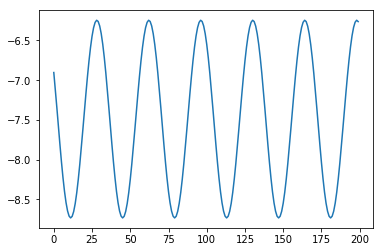

10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700


KeyboardInterrupt: 

In [240]:
target_actor = Actor()
target_critic = Critic()
actor = Actor()
critic = Critic()
if use_cuda:
    target_actor.cuda()
    target_critic.cuda()
    actor.cuda()
    critic.cuda()
exp = Experience(EXPERIENCE_CAPACITY)
optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

vec_r = []
update_counter = 0
for epi in xrange(MAX_EPI):
    o = env.reset()
    acc_r = 0
    
    local_r = []
    
    for t in xrange(MAX_STEP):    
        #a = choose_action(o, critic)
        a = choose_action(o, actor)
        #a = np.random.normal(a, 3)
        #a = np.clip(a, -2, 2)
        
        o_, r, done, info = env.step(a)
        exp.push(o, a, r, o_)
        
        dict_critic = copy.deepcopy(critic.state_dict())
        
        update_actor_critic(target_actor, target_critic, \
                           actor, critic, exp, optim_actor, optim_critic)
        update_counter += 1
        
        dict_critic_diff = {}
        for key in dict_critic:
            dict_critic_diff[key] = torch.sum(critic.state_dict()[key] - dict_critic[key])
        #print dict_critic_diff
        
        
        if update_counter % TARGET_UPDATE_FREQUENCY == 0:
            update_target(target_actor, target_critic, \
                         actor, critic)
        #if update_counter % 300 == 0:
        #    replace(target_critic, critic)
        #if update_counter % 500 == 0:
        #    replace(target_actor, actor)
        
        local_r.append(r)
        acc_r += r
        o = o_
        if done:
            break
            
    if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
        plt.plot(xrange(len(local_r)), local_r)
        plt.show()
    
    if epi % (MAX_EPI/1000) == 0:
        print epi
        vec_r.append(acc_r)

plt.plot(xrange(1000), vec_r)
plt.show()

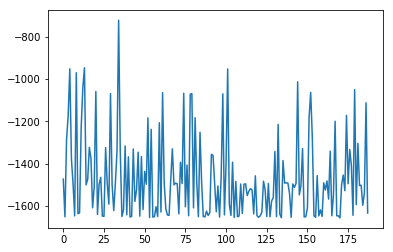

In [241]:
plt.plot(xrange(len(vec_r)), vec_r)
plt.show()

[[ 0.16427136  0.64244842  0.45357675  0.22938096]]


[2017-08-08 21:20:15,016] Making new env: Pendulum-v0


[-0.1640642]
[-0.0849174]
[-0.00866966]
[ 0.06596601]
[ 0.13923977]
[ 0.21203007]
[ 0.28579655]
[ 0.36244231]
[ 0.44073889]
[ 0.52144474]
[ 0.60529345]
[ 0.69318259]
[ 0.78605139]
[ 0.884763]
[ 0.98993385]
[ 1.10168076]
[ 1.216295]
[ 1.33302939]
[ 1.44739282]
[ 1.5493803]
[ 1.62572742]
[ 1.66499364]
[ 1.66443539]
[ 1.62164724]
[ 1.54486454]
[ 1.44527996]
[ 1.33004284]
[ 1.20712614]
[ 1.08329797]
[ 0.96380937]
[ 0.85223436]
[ 0.75049084]
[ 0.65885466]
[ 0.57661128]
[ 0.49886397]
[ 0.42565638]
[ 0.35534954]
[ 0.28611961]
[ 0.21542458]
[ 0.14340994]
[ 0.06956072]
[-0.00543683]
[-0.0803756]
[-0.15327579]
[-0.22122335]
[-0.28128701]
[-0.32935733]
[-0.36407083]
[-0.38367337]
[-0.38566864]
[-0.3841182]
[-0.37755901]
[-0.36471009]
[-0.36106595]
[-0.36709726]
[-0.38410762]
[-0.40329769]
[-0.42640886]
[-0.45366934]
[-0.48743021]
[-0.55005145]
[-0.63220572]
[-0.75929505]
[-0.9901818]
[-1.30199862]
[-1.68683028]
[-2.18595719]
[-2.7661581]
[-3.34107876]
[-3.88359427]
[-4.36560106]
[-4.76042843]
[-5

[ 1.85817158]
[ 1.57621908]
[ 1.34273577]
[ 1.17753053]
[ 1.21609461]
[ 1.43353164]
[ 1.80433834]
[ 2.30832934]
[ 2.97489333]
[ 3.60769916]
[ 4.07199192]
[ 4.36461926]
[ 4.45308542]
[ 4.35687828]
[ 4.3907032]
[ 4.26813316]
[ 3.92699766]
[ 3.4201951]
[ 2.86497641]
[ 2.3383019]
[ 1.88482177]
[ 1.76834095]
[ 1.90119159]
[ 2.21012592]
[ 2.67033339]
[ 3.22895312]
[ 3.62542653]
[ 3.8883543]
[ 3.95877481]
[ 3.83496547]
[ 3.57491207]
[ 3.35389566]
[ 3.15953064]
[ 2.84410024]
[ 2.45518756]
[ 2.05017519]
[ 1.68231213]
[ 1.44746816]
[ 1.51773942]
[ 1.72585547]
[ 2.09465933]
[ 2.61127734]
[ 3.21814656]
[ 3.67998481]
[ 4.01714802]
[ 4.16324043]
[ 4.12754917]
[ 3.95966172]
[ 3.94790387]
[ 3.83826613]
[ 3.56829405]
[ 3.20576978]
[ 2.80983114]
[ 2.4368248]
[ 2.17796135]
[ 2.30818295]
[ 2.61136818]
[ 3.11065149]
[ 3.77296591]
[ 4.33035612]
[ 4.74079323]
[ 4.98984718]
[ 5.03269291]
[ 4.91390038]
[ 4.82276201]
[ 4.77345467]
[ 4.5057292]
[ 4.06909418]
[ 3.57144427]
[ 3.06685019]
[ 2.62134409]
[ 2.38475084

[-5.78344154]
[-4.67287588]
[-5.05572033]
[-5.90450382]
[-6.35589695]
[-6.36076927]
[-6.66019678]
[-6.98560905]
[-7.12786818]
[-7.05464172]
[-7.50211811]
[-7.83994961]
[-7.98154068]
[-8.00999737]
[-7.98632669]
[-7.7293992]
[-7.2522912]
[-6.50424051]
[-5.9928751]
[-6.47441387]
[-6.82511568]
[-6.65966988]
[-6.03583097]
[-5.77557755]
[-5.56403112]
[-5.28285456]
[-4.9733386]
[-5.21544409]
[-5.52828169]
[-5.83743382]
[-6.19707537]
[-6.36449099]
[-6.32927895]
[-6.05901766]
[-5.80489779]
[-6.11776066]
[-6.89399624]
[-7.43584108]
[-7.4814043]
[-7.31637192]
[-7.43486738]
[-7.29314518]
[-6.93304491]
[-6.89434147]
[-7.05369759]
[-7.13900471]
[-7.2016058]
[-7.1923604]
[-7.06842232]
[-6.84381437]
[-6.50357294]
[-6.21515942]
[-6.10555172]
[-6.59223652]
[-6.69017315]
[-6.3960495]
[-6.2192378]
[-6.25110102]
[-6.11402798]
[-5.84571171]
[-6.14790535]
[-6.40620327]
[-6.61735868]
[-6.83904791]
[-7.01606417]
[-7.1342535]
[-7.16940832]
[-7.08250904]
[-7.0553751]
[-7.09447527]
[-7.49339104]
[-7.40217781]
[-6

[-13.21170998]
[-13.22642899]
[-13.2500124]
[-13.29179955]
[-13.355793]
[-13.44267654]
[-13.5384388]
[-13.63508129]
[-13.72704697]
[-13.8136034]
[-13.89987469]
[-14.00047779]
[-14.13281727]
[-14.31426811]
[-14.51102257]
[-14.71469307]
[-14.91444016]
[-15.10377502]
[-15.27222347]
[-15.42332077]
[-15.67783928]
[-15.88864231]
[-16.06102562]
[-16.16021156]
[-16.20253372]
[-16.21069527]
[-16.17248154]
[-16.10612679]
[-16.00593376]
[-15.92264938]
[-15.86030197]
[-15.80218601]
[-15.7443409]
[-15.67702198]
[-15.60790253]
[-15.52725887]
[-15.44197464]
[-15.42314625]
[-15.44920635]
[-15.45789051]
[-15.4531517]
[-15.42797565]
[-15.38035202]
[-15.31592941]
[-15.22841835]
[-15.12413597]
[-15.01615143]
[-14.94615746]
[-14.88016415]
[-14.8146162]
[-14.75222778]
[-14.69316769]
[-14.64248085]
[-14.60456181]
[-14.58020496]
[-14.65779209]
[-14.79096603]
[-14.94365883]
[-15.12115574]
[-15.29498959]
[-15.46437168]
[-15.63683319]
[-15.79771233]
[-15.98377132]
[-16.15020752]
[-16.28028679]
[-16.37464333]
[-1

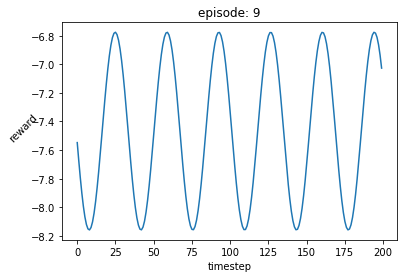

[-14.06785011]
[-14.10300636]
[-14.15474033]
[-14.21451378]
[-14.25976753]
[-14.3207922]
[-14.39771748]
[-14.46084023]
[-14.48151207]
[-14.88990116]
[-15.45475388]
[-15.88379383]
[-16.0848732]
[-16.05475426]
[-15.72297573]
[-16.23219872]
[-16.73893929]
[-17.10664177]
[-17.18683052]
[-17.01942825]
[-16.70942307]
[-16.35274506]
[-16.21669579]
[-16.13382912]
[-16.14522934]
[-16.54233551]
[-17.18557358]
[-17.80587769]
[-18.28532791]
[-18.51607895]
[-18.55986214]
[-18.45752525]
[-19.05145645]
[-19.65294075]
[-19.94866371]
[-19.97305298]
[-19.78277588]
[-19.98017311]
[-20.15467834]
[-20.20057297]
[-20.17233276]
[-20.12775612]
[-20.09781837]
[-20.055233]
[-20.01641273]
[-19.98670387]
[-19.93995857]
[-19.93155861]
[-19.90232468]
[-19.85010338]
[-19.83721352]
[-19.91584015]
[-20.04986191]
[-20.2420845]
[-20.47265625]
[-20.74180794]
[-21.01047897]
[-21.24490738]
[-21.63724327]
[-22.56952286]
[-23.36685562]
[-23.85564041]
[-23.8871727]
[-23.39770889]
[-22.54235649]
[-22.8351326]
[-22.85751152]
[-

[-12.60524845]
[-12.86380577]
[-12.76393032]
[-12.34154034]
[-12.43601608]
[-12.57374191]
[-12.17736149]
[-11.44001675]
[-11.11067295]
[-10.67209148]
[-9.90251446]
[-9.73221397]
[-10.0880394]
[-10.23151684]
[-10.27803516]
[-10.36423588]
[-10.26326466]
[-10.32231617]
[-10.84690475]
[-10.99479103]
[-11.26353264]
[-12.2320919]
[-12.6718092]
[-12.64347744]
[-12.4265976]
[-13.11651134]
[-11.57543468]
[-12.04489422]
[-12.62378597]
[-13.26563358]
[-13.9070015]
[-14.43567085]
[-14.66300201]
[-14.81774998]
[-15.25477791]
[-14.89020824]
[-14.01102638]
[-13.77780628]
[-13.36274815]
[-12.58712006]
[-12.29704189]
[-12.28458023]
[-12.27660179]
[-12.48784447]
[-12.66478157]
[-12.67382145]
[-12.36233139]
[-12.79070473]
[-12.52494049]
[-12.41230392]
[-12.66844463]
[-12.8617239]
[-12.77721691]
[-12.32526398]
[-12.67091846]
[-12.50096607]
[-11.91360474]
[-12.07924461]
[-12.48612595]
[-12.63398266]
[-12.64227867]
[-12.67645645]
[-12.52962494]
[-12.26581001]
[-12.69453526]
[-12.49303436]
[-12.52556324]
[-1

[-14.83939648]
[-11.27688885]
[-11.26864815]
[-11.22318077]
[-11.1323204]
[-10.99956894]
[-10.84321117]
[-10.67393303]
[-10.49354362]
[-10.30403233]
[-10.10684395]
[-9.91150379]
[-9.7356863]
[-9.60281372]
[-9.51716614]
[-9.54221249]
[-9.61467934]
[-9.69497299]
[-9.77285194]
[-9.84176922]
[-9.90126419]
[-9.95244598]
[-9.99192047]
[-10.08447266]
[-10.20875359]
[-10.32333183]
[-10.43015957]
[-10.53137112]
[-10.63427544]
[-10.74140167]
[-10.85410976]
[-10.96497917]
[-11.07447624]
[-11.18596554]
[-11.30379677]
[-11.4384222]
[-11.58573151]
[-11.73865128]
[-11.88527012]
[-12.01233387]
[-12.12291145]
[-12.21844673]
[-12.29819202]
[-12.35816765]
[-12.3917675]
[-12.39435863]
[-12.3664341]
[-12.31744766]
[-12.36892033]
[-12.40422726]
[-12.41321468]
[-12.40033531]
[-12.36723518]
[-12.31542778]
[-12.24958515]
[-12.1746273]
[-12.09156799]
[-12.0273695]
[-12.05882359]
[-12.09592342]
[-12.12995434]
[-12.15857887]
[-12.1820097]
[-12.19947433]
[-12.21083641]
[-12.21455479]
[-12.20921898]
[-12.20014191]


[-6.01942158]
[-5.70038843]
[-5.92568016]
[-6.06378412]
[-6.04717875]
[-5.92709398]
[-5.76143551]
[-6.00484037]
[-6.06721973]
[-5.99197865]
[-6.03743315]
[-6.29377794]
[-6.44532633]
[-6.48232222]
[-6.39349985]
[-6.40421438]
[-6.63563156]
[-6.421772]
[-6.23322392]
[-6.41069841]
[-6.49753857]
[-6.38762903]
[-6.16567469]
[-6.10967016]
[-6.14942551]
[-6.01164341]
[-5.75895214]
[-5.7496376]
[-5.58596277]
[-5.53288078]
[-5.47606707]
[-5.41320324]
[-5.34508801]
[-5.25928211]
[-5.12780094]
[-5.1241684]
[-5.35183001]
[-5.45094061]
[-5.38773441]
[-5.22690201]
[-5.13110924]
[-5.27848864]
[-5.27990818]
[-5.16551304]
[-5.16344261]
[-5.29880381]
[-5.32457542]
[-5.25067091]
[-5.06293154]
[-5.15578079]
[-5.22241211]
[-5.01896572]
[-5.09315825]
[-5.24865055]
[-5.32524252]
[-5.28795624]
[-5.18363571]
[-5.32858562]
[-5.52677679]
[-5.59831142]
[-5.56841469]
[-5.86621761]
[-6.14154673]
[-6.32991457]
[-6.4557333]
[-6.5044055]
[-7.01245975]
[-7.27117825]
[-7.20287037]
[-7.51627111]
[-8.05810833]
[-8.36031437

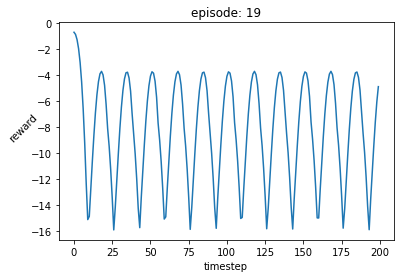

[-6.23629856]
[-6.21072721]
[-6.19813299]
[-6.1741519]
[-6.11712742]
[-5.99266243]
[-6.23950911]
[-6.47409725]
[-6.56028557]
[-6.45857954]
[-6.3081522]
[-6.52924776]
[-6.55749416]
[-6.44408751]
[-6.35178947]
[-6.59497309]
[-6.77819967]
[-6.88849449]
[-6.93859529]
[-6.94592953]
[-7.42466974]
[-7.46828985]
[-7.27828455]
[-7.6408658]
[-8.09139061]
[-8.24786949]
[-8.08892727]
[-8.20395756]
[-8.40087795]
[-8.40289688]
[-8.2316618]
[-8.35993195]
[-8.51339817]
[-8.56592751]
[-8.54676628]
[-8.47449493]
[-8.43891907]
[-8.85824203]
[-8.74876785]
[-8.47778225]
[-9.00611877]
[-9.40959072]
[-9.47846222]
[-9.47153091]
[-9.82823181]
[-10.00706863]
[-10.01736069]
[-9.97300339]
[-10.24730873]
[-10.4006052]
[-10.4586401]
[-10.50472355]
[-10.46776199]
[-10.50668621]
[-10.75839806]
[-10.41091728]
[-10.32990742]
[-10.64382553]
[-10.6926012]
[-10.37658405]
[-10.4301796]
[-10.36046791]
[-10.13742065]
[-9.74379635]
[-9.45381451]
[-9.34983253]
[-9.17170525]
[-8.94010353]
[-8.71203995]
[-8.43844795]
[-8.6779460

[-10.96266365]
[-10.50971317]
[-10.3373127]
[-10.36326218]
[-10.40975189]
[-10.44399834]
[-10.47299576]
[-10.50487232]
[-10.55896378]
[-10.65491962]
[-10.80862045]
[-11.02876282]
[-11.30796528]
[-11.64001846]
[-12.0258112]
[-12.46042633]
[-12.83475971]
[-13.11786747]
[-13.27570438]
[-13.27916622]
[-13.12581348]
[-13.05476952]
[-13.11962891]
[-13.09503269]
[-13.01583099]
[-12.90672302]
[-12.78222084]
[-12.65074062]
[-12.52747059]
[-12.4243803]
[-12.32556057]
[-12.22625637]
[-12.10627651]
[-11.95086288]
[-11.7473793]
[-11.48510551]
[-11.15573978]
[-10.75854683]
[-10.30238914]
[-10.09402943]
[-10.10852718]
[-10.14020634]
[-10.18104553]
[-10.23733711]
[-10.31197166]
[-10.42629433]
[-10.59374809]
[-10.80180073]
[-11.05174732]
[-11.32758522]
[-11.6154108]
[-11.90943432]
[-12.23210621]
[-12.45971394]
[-12.56155491]
[-12.52349567]
[-12.33693504]
[-12.02090836]
[-11.66396427]
[-11.58168316]
[-11.41817284]
[-11.19066238]
[-10.92695427]
[-10.65864944]
[-10.40706158]
[-10.18715954]
[-10.00508404]


[-18.27295685]
[-17.81448174]
[-17.34464073]
[-16.89693832]
[-16.48689461]
[-16.0986805]
[-15.71649361]
[-12.33851337]
[-13.72661686]
[-15.06033325]
[-16.28575897]
[-17.3123436]
[-18.03941154]
[-18.42529488]
[-18.44699287]
[-18.14183998]
[-18.01634598]
[-17.89204025]
[-17.57772636]
[-17.13755798]
[-16.62101936]
[-16.07700348]
[-15.52929688]
[-15.01482677]
[-14.63201809]
[-14.21317577]
[-13.75133991]
[-13.23206806]
[-12.64509964]
[-12.09891796]
[-11.56118011]
[-10.96837044]
[-10.30155087]
[-9.55351067]
[-8.82650852]
[-8.28548336]
[-7.86580467]
[-7.75753117]
[-7.82674265]
[-7.77282]
[-7.61155796]
[-7.33919668]
[-7.17768335]
[-7.79397821]
[-8.55285358]
[-9.43994617]
[-10.43630028]
[-11.5189476]
[-12.66186905]
[-13.83682823]
[-15.0022459]
[-16.14828682]
[-17.14089584]
[-17.90486717]
[-18.37961006]
[-18.53358269]
[-18.37502098]
[-18.50168037]
[-18.55975723]
[-18.39703751]
[-18.07071114]
[-17.64203072]
[-17.1486187]
[-16.62754631]
[-16.23877335]
[-15.82873726]
[-15.37231636]
[-14.87843037]
[

[-17.38071823]
[-16.52169418]
[-17.00798035]
[-17.22050667]
[-17.12626266]
[-16.68961334]
[-15.90866184]
[-15.19668293]
[-15.27414799]
[-15.04042053]
[-15.40756226]
[-15.81259346]
[-15.98359871]
[-15.9111805]
[-15.6225853]
[-16.57987213]
[-17.13761139]
[-16.81671715]
[-16.77353287]
[-17.41630363]
[-17.8012352]
[-18.05537796]
[-17.64308167]
[-16.91838264]
[-17.3230629]
[-17.53226852]
[-17.92080307]
[-18.76311874]
[-19.35671997]
[-19.71056366]
[-19.8335228]
[-19.67615891]
[-20.99114609]
[-21.39101028]
[-21.06779099]
[-20.95461655]
[-22.83372879]
[-23.93370819]
[-24.19218063]
[-23.64936066]
[-23.72569275]
[-23.5775528]
[-23.37479019]
[-18.38807678]
[-18.63956451]
[-18.86811066]
[-19.06570435]
[-19.23039436]
[-19.35569]
[-19.42404938]
[-20.17845154]
[-21.412817]
[-22.67495918]
[-24.07813835]
[-25.15504265]
[-26.78057289]
[-27.70166969]
[-27.63149834]
[-26.62878609]
[-26.57387161]
[-25.7310009]
[-25.27184105]
[-24.91119194]
[-24.96140671]
[-24.75776482]
[-24.36155128]
[-23.78513718]
[-23.21

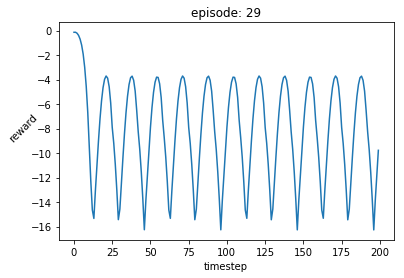

[-13.95402622]
[-13.93742275]
[-14.01429939]
[-14.17084789]
[-14.33668137]
[-14.47448349]
[-14.5559206]
[-14.56464291]
[-14.49808025]
[-14.36342144]
[-14.18076324]
[-13.99761677]
[-14.25968456]
[-14.46840858]
[-14.63371468]
[-14.76256466]
[-14.86052418]
[-14.92901134]
[-14.96821213]
[-14.98496151]
[-14.97820854]
[-14.94194031]
[-14.86977005]
[-14.74249935]
[-14.54719162]
[-14.28975487]
[-14.31659889]
[-14.50922298]
[-14.73480415]
[-14.92525673]
[-15.07494354]
[-15.21826935]
[-15.37553883]
[-15.57689953]
[-15.85358143]
[-16.21722603]
[-16.65646362]
[-17.19639778]
[-17.85546875]
[-18.62960434]
[-19.39345551]
[-20.09119415]
[-20.67027473]
[-21.06552696]
[-21.24987221]
[-21.21680069]
[-21.32231903]
[-21.59748077]
[-21.67757988]
[-21.58785439]
[-21.35289383]
[-20.99827385]
[-20.55833244]
[-20.06920624]
[-19.54829216]
[-19.00965881]
[-18.46458817]
[-17.91581154]
[-17.35968971]
[-16.79826355]
[-16.22870445]
[-15.69159412]
[-15.8267746]
[-16.00831032]
[-16.27204132]
[-16.50231743]
[-16.6928424

[-11.49197674]
[-11.6564312]
[-11.96439934]
[-11.58670235]
[-11.76037502]
[-11.79213905]
[-11.91394615]
[-11.97577286]
[-11.8182106]
[-11.57448769]
[-11.97194767]
[-12.10603046]
[-12.01950073]
[-11.78365993]
[-11.88781929]
[-12.05161381]
[-12.14717865]
[-12.0240469]
[-12.34490108]
[-12.43501568]
[-12.25501633]
[-12.49570465]
[-12.61102676]
[-13.02705574]
[-13.15271187]
[-12.89918137]
[-12.95354652]
[-13.28499603]
[-13.29507828]
[-13.06036663]
[-12.69863892]
[-12.8705492]
[-12.95603848]
[-12.90463448]
[-12.61970615]
[-13.02875805]
[-12.64653587]
[-12.47752094]
[-12.43470287]
[-12.27251625]
[-12.24728775]
[-11.93181038]
[-11.41462708]
[-11.1658392]
[-11.0340662]
[-10.71362209]
[-11.76310825]
[-11.73837852]
[-11.70472622]
[-11.65894413]
[-11.59426785]
[-11.50426674]
[-11.46953487]
[-11.53468895]
[-11.57170868]
[-11.56899452]
[-11.51924515]
[-11.45651436]
[-11.37418365]
[-11.26673222]
[-11.14805603]
[-11.02176857]
[-10.89214134]
[-10.76373577]
[-10.66862011]
[-10.55838108]
[-10.48641014]
[

[-23.26565361]
[-23.09545517]
[-23.27533913]
[-24.51976013]
[-24.31734467]
[-23.81696892]
[-23.82798576]
[-24.49134445]
[-24.77044106]
[-24.68873596]
[-24.59546471]
[-24.83863258]
[-24.46172714]
[-24.19207954]
[-24.39143181]
[-24.40053558]
[-24.27977753]
[-24.04296303]
[-23.69034004]
[-24.12734604]
[-24.71003151]
[-24.20948601]
[-23.44981384]
[-23.75932503]
[-24.12686539]
[-24.12015152]
[-23.71686172]
[-23.69291115]
[-23.62803841]
[-23.05447388]
[-23.00509834]
[-23.17399406]
[-23.19757843]
[-23.10397911]
[-22.88721466]
[-22.51913452]
[-23.58233643]
[-23.56201553]
[-22.97633362]
[-22.44603539]
[-23.03469849]
[-23.26415253]
[-23.26675415]
[-22.5883007]
[-23.2455864]
[-23.35823631]
[-23.47100449]
[-23.54869843]
[-23.55891037]
[-23.45986366]
[-23.22966957]
[-22.87634468]
[-23.05836487]
[-23.17780304]
[-23.1381855]
[-22.97509003]
[-22.70519066]
[-22.39097214]
[-22.0861187]
[-21.83543205]
[-21.67152405]
[-21.61238861]
[-21.65947723]
[-21.80382538]
[-22.12148666]
[-22.57811165]
[-22.99064636]

[-18.6563797]
[-18.60585976]
[-18.56809235]
[-18.57367325]
[-18.55017471]
[-18.48903465]
[-18.37457848]
[-18.21796417]
[-18.03619576]
[-17.84609604]
[-17.64574432]
[-17.71551895]
[-17.864748]
[-17.99085236]
[-18.09947395]
[-18.18792915]
[-18.2559185]
[-18.31839752]
[-18.37814903]
[-18.43387794]
[-18.45958138]
[-18.46105003]
[-18.43151665]
[-18.3609581]
[-18.49332619]
[-18.71300507]
[-18.88414955]
[-18.99947739]
[-19.07877541]
[-19.13892746]
[-19.25308609]
[-19.34235001]
[-19.41563606]
[-19.4823494]
[-19.54533005]
[-19.60260582]
[-19.65620232]
[-19.70792961]
[-19.77775383]
[-19.8122406]
[-19.75673103]
[-19.61294365]
[-19.37885475]
[-19.08185577]
[-18.74992561]
[-18.39118385]
[-18.28773117]
[-18.26642418]
[-18.25298119]
[-18.25878716]
[-18.28903389]
[-18.34335518]
[-18.40491104]
[-18.4658947]
[-18.51649666]
[-18.55510521]
[-18.56768227]
[-18.56572723]
[-18.51268768]
[-18.57659912]
[-18.78561974]
[-18.94186211]
[-19.03900146]
[-19.08441925]
[-19.09505844]
[-19.15229034]
[-19.2244873]
[-19

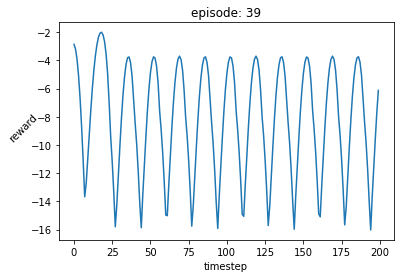

[-18.07196617]
[-17.9021244]
[-17.69722366]
[-17.4513073]
[-17.90744209]
[-18.47207832]
[-18.97757149]
[-19.19717598]
[-19.0555687]
[-18.54214859]
[-18.42500305]
[-18.43125153]
[-18.18869781]
[-17.75844002]
[-17.21101952]
[-16.90720177]
[-16.92887878]
[-16.85938263]
[-16.7025547]
[-16.44259644]
[-16.05150032]
[-15.90722942]
[-15.75973797]
[-15.72054195]
[-16.19207191]
[-16.32290649]
[-16.56447792]
[-16.88409805]
[-17.05648232]
[-17.07999611]
[-16.96796799]
[-16.60675621]
[-17.19765282]
[-17.44650269]
[-17.41707993]
[-17.21759605]
[-17.90499687]
[-18.41213226]
[-18.71879005]
[-18.7815094]
[-18.87958717]
[-19.58104324]
[-19.23608971]
[-19.45851898]
[-20.43811417]
[-21.27579308]
[-21.38985252]
[-20.79101181]
[-20.50413132]
[-20.38781929]
[-20.10723495]
[-19.55368805]
[-19.42876434]
[-19.59914207]
[-19.57888794]
[-19.35764122]
[-18.88173103]
[-18.90997314]
[-18.6485424]
[-17.82679939]
[-18.00160027]
[-18.01983452]
[-17.85500336]
[-17.50042343]
[-16.93767357]
[-16.88541603]
[-16.90917397]
[

[-4.1731205]
[-4.20455265]
[-4.22300053]
[-4.22325659]
[-4.21618271]
[-4.18251133]
[-4.15662193]
[-4.15482378]
[-4.17142725]
[-4.20479393]
[-4.25485849]
[-4.29870939]
[-4.34008694]
[-4.37573195]
[-4.40134001]
[-4.4147644]
[-4.40953445]
[-4.39873981]
[-4.39198875]
[-4.40888214]
[-4.44289207]
[-4.47535944]
[-4.53060436]
[-4.62744331]
[-4.75937843]
[-4.91568851]
[-5.08544207]
[-5.23768425]
[-5.34347725]
[-5.3987546]
[-5.45445538]
[-5.47911215]
[-5.47418356]
[-5.45186138]
[-5.42045593]
[-5.41683769]
[-5.47265339]
[-5.54497147]
[-5.51147842]
[-5.47383261]
[-5.40450191]
[-5.29579592]
[-5.14387226]
[-4.95662117]
[-4.73505306]
[-4.48658562]
[-4.27225542]
[-4.07493734]
[-3.91441226]
[-3.79457045]
[-3.71616888]
[-3.68028259]
[-3.61573267]
[-3.53022909]
[-3.43907237]
[-3.35767746]
[-3.27343559]
[-3.1947875]
[-3.13517046]
[-3.10028124]
[-3.09196401]
[-3.11913371]
[-3.1702733]
[-3.20473075]
[-3.21867394]
[-3.26116467]
[-3.32295799]
[-3.39737463]
[-3.47115517]
[-3.48072863]
[-3.47860599]
[-3.4889931

[-5.9279871]
[-5.92905235]
[-5.95073318]
[-5.92808056]
[-5.85167694]
[-5.6771884]
[-5.43532181]
[-5.16778708]
[-4.93735027]
[-4.78328991]
[-4.63474464]
[-4.49783993]
[-4.36817169]
[-4.23509884]
[-4.09379864]
[-3.94179535]
[-3.84168601]
[-3.81637144]
[-3.81961632]
[-3.83971167]
[-3.86575317]
[-3.88342905]
[-3.88048863]
[-3.85959983]
[-3.82701111]
[-3.78940439]
[-3.82047606]
[-3.84623885]
[-3.85463047]
[-3.86144567]
[-3.81374502]
[-3.76653862]
[-3.73081326]
[-3.77162075]
[-3.84196377]
[-3.9282515]
[-4.01508236]
[-4.08868122]
[-4.12705135]
[-4.12509823]
[-4.09164953]
[-4.03870773]
[-4.00483131]
[-4.01884937]
[-4.01461506]
[-4.00654221]
[-3.98654556]
[-3.90357947]
[-3.83900452]
[-3.80637836]
[-3.84035587]
[-3.89922905]
[-3.96793795]
[-4.03067684]
[-4.07473373]
[-4.0762043]
[-4.04001379]
[-3.97820711]
[-3.90354872]
[-3.86871052]
[-3.85956264]
[-3.83535981]
[-3.79569173]
[-3.73484635]
[-3.65532207]
[-3.57957959]
[-3.57725382]
[-3.6115396]
[-3.67013502]
[-3.74037242]
[-3.80993032]
[-3.8627653

[-7.76023293]
[-7.6924057]
[-7.64780235]
[-7.63746452]
[-7.66203117]
[-7.73966837]
[-7.76140356]
[-7.7475543]
[-7.69642639]
[-7.63012505]
[-7.67386389]
[-7.60385513]
[-7.38520956]
[-7.02481747]
[-6.58397675]
[-6.1310358]
[-5.72433758]
[-5.4055829]
[-5.11631346]
[-4.8470459]
[-4.59066772]
[-4.33817577]
[-4.16138983]
[-4.01784658]
[-3.91108656]
[-3.81869173]
[-3.71785259]
[-3.59879827]
[-3.4640274]
[-3.32649684]
[-3.19788122]
[-3.08750725]
[-2.99899006]
[-2.92878985]
[-2.87184048]
[-2.8241117]
[-2.7775836]
[-2.73409224]
[-2.69579506]
[-2.67812014]
[-2.70797086]
[-2.75651407]
[-2.8144505]
[-2.89055061]
[-2.98127127]
[-3.07269239]
[-3.16333199]
[-3.24553037]
[-3.31426001]
[-3.36842632]
[-3.41006422]
[-3.44222927]
[-3.46809101]
[-3.49044061]
[-3.51138377]
[-3.53332376]
[-3.53733873]
[-3.5379405]
[-3.54496861]
[-3.56069279]
[-3.58416557]
[-3.61117172]
[-3.63512468]
[-3.65039158]
[-3.65935564]
[-3.66409373]
[-3.66705036]
[-3.66864681]
[-3.67248106]
[-3.67928839]
[-3.69241929]
[-3.70880747]
[-

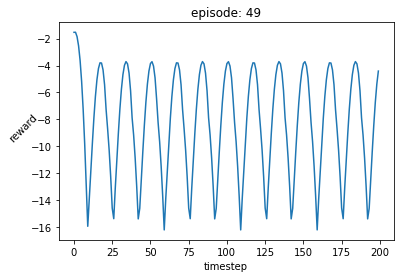

[-4.32725763]
[-4.33605433]
[-4.34253979]
[-4.34631491]
[-4.34822941]
[-4.34867859]
[-4.3458395]
[-4.33937836]
[-4.3289032]
[-4.31381035]
[-4.29446793]
[-4.27060938]
[-4.24347687]
[-4.21239471]
[-4.17625332]
[-4.13484049]
[-4.08874083]
[-4.03883362]
[-3.9861002]
[-3.93109894]
[-3.87482786]
[-3.82061172]
[-3.76892662]
[-3.7196393]
[-3.67299652]
[-3.62875795]
[-3.58648992]
[-3.54581356]
[-3.50643778]
[-3.46843529]
[-3.43191242]
[-3.39700031]
[-3.36419201]
[-3.33364367]
[-3.30548668]
[-3.28193545]
[-3.26369524]
[-3.25316906]
[-3.25004673]
[-3.2539618]
[-3.2652123]
[-3.28294706]
[-3.30761385]
[-3.3394568]
[-3.37880421]
[-3.42580175]
[-3.48010731]
[-3.54194641]
[-3.61073112]
[-3.68630457]
[-3.7674613]
[-3.85373116]
[-3.94332504]
[-4.03401947]
[-4.12492561]
[-4.21591949]
[-4.30415487]
[-4.39020109]
[-4.47296143]
[-4.550807]
[-4.62183952]
[-4.68533707]
[-4.74063492]
[-4.78535318]
[-4.81614351]
[-4.83373642]
[-4.83796406]
[-4.82880211]
[-4.81016016]
[-4.78774166]
[-4.76324368]
[-4.73705959]
[-

[-3.06078005]
[-3.06773043]
[-3.06514502]
[-3.0483284]
[-3.02428436]
[-3.00866222]
[-2.99299574]
[-2.99336219]
[-2.99613833]
[-2.99995518]
[-3.0080905]
[-3.02474427]
[-3.0469172]
[-3.06850147]
[-3.08334851]
[-3.09175825]
[-3.09384537]
[-3.09062862]
[-3.08220291]
[-3.0531168]
[-3.01905298]
[-2.99133539]
[-2.97961593]
[-2.98156714]
[-2.99812174]
[-3.02175951]
[-3.02870059]
[-3.03540611]
[-3.03760886]
[-3.03497124]
[-3.02866602]
[-3.01991034]
[-3.00832915]
[-2.9952333]
[-2.98011017]
[-2.95619059]
[-2.91645956]
[-2.87619543]
[-2.8459959]
[-2.8263607]
[-2.81393147]
[-2.81325793]
[-2.81010866]
[-2.7944169]
[-2.7853272]
[-2.78340864]
[-2.78948283]
[-2.80430937]
[-2.82491517]
[-2.84855652]
[-2.87328982]
[-2.89873886]
[-2.91143823]
[-2.92236114]
[-2.93484068]
[-2.9506371]
[-2.96882677]
[-2.98843479]
[-3.00815392]
[-3.01479816]
[-3.02248526]
[-3.03165364]
[-3.04131126]
[-3.05006289]
[-3.05682063]
[-3.06128263]
[-3.06370091]
[-3.06402183]
[-3.06142402]
[-3.05040836]
[-3.03362894]
[-3.01379776]
[-

[-5.96848011]
[-5.86032104]
[-5.76724386]
[-5.75976515]
[-5.78421688]
[-5.82994127]
[-5.87799406]
[-5.92137051]
[-5.95760441]
[-5.98507214]
[-6.00335598]
[-6.0100832]
[-6.01113033]
[-6.01399803]
[-6.00308752]
[-5.97563648]
[-6.0437212]
[-6.14153957]
[-6.18594456]
[-6.17291927]
[-6.10343361]
[-5.98630619]
[-5.8371954]
[-5.66917419]
[-5.49403286]
[-5.32564831]
[-5.2122035]
[-5.15417147]
[-5.10913849]
[-5.08756351]
[-5.06156635]
[-5.03283978]
[-5.00016499]
[-4.96426964]
[-4.91953278]
[-4.87221098]
[-4.82634354]
[-4.78182507]
[-4.74140835]
[-4.70667934]
[-4.67792845]
[-4.65570927]
[-4.63937235]
[-4.6292038]
[-4.61760139]
[-4.6072998]
[-4.60387611]
[-4.60745668]
[-4.61171532]
[-4.59886074]
[-4.57220888]
[-4.53320122]
[-4.47344589]
[-4.41829205]
[-4.37551069]
[-4.34638739]
[-4.3428688]
[-4.36532593]
[-4.40101767]
[-4.41573954]
[-4.38078165]
[-4.32696676]
[-4.3029995]
[-4.33753109]
[-4.36826706]
[-4.39087868]
[-4.4015975]
[-4.39928102]
[-4.38763809]
[-4.36934185]
[-4.3468895]
[-4.32304525]
[-

[-5.18134499]
[-5.18616772]
[-5.19244719]
[-5.19938612]
[-5.20936871]
[-5.21803665]
[-5.22481823]
[-5.23122168]
[-5.23845291]
[-5.24931002]
[-5.26363754]
[-5.28018332]
[-5.29693031]
[-5.31405449]
[-5.3258667]
[-5.3313427]
[-5.33084488]
[-5.32568502]
[-5.31548119]
[-5.30125427]
[-5.28667641]
[-5.27030563]
[-5.25195694]
[-5.22972679]
[-5.20298243]
[-5.17429924]
[-5.14694595]
[-5.12572813]
[-5.11236095]
[-5.10234404]
[-5.09544086]
[-5.09121656]
[-5.08976555]
[-5.09017324]
[-5.09192944]
[-5.09397411]
[-5.09508562]
[-5.09544277]
[-5.09779453]
[-5.10197401]
[-5.10701275]
[-5.11255312]
[-5.11833382]
[-5.12282181]
[-5.12534475]
[-5.12785864]
[-5.13107014]
[-5.13409185]
[-5.13900614]
[-5.14191389]
[-5.14480495]
[-5.14864635]
[-5.15365744]
[-5.15605068]
[-5.15470505]
[-5.15003204]
[-5.14394712]
[-5.14229774]
[-5.14607382]
[-5.15601969]
[-5.17332077]
[-5.20122337]
[-5.23799658]
[-5.2810297]
[-5.32548046]
[-5.36612034]
[-5.40276003]
[-5.43628025]
[-5.46779251]
[-5.49822617]
[-5.52920914]
[-5.56276

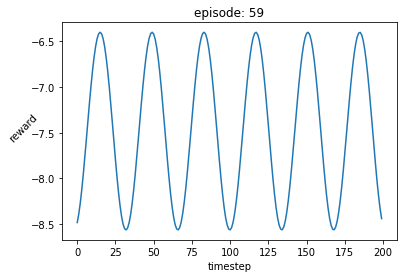

[-6.24342442]
[-6.3689003]
[-6.49180984]
[-6.61330795]
[-6.73237467]
[-6.83952808]
[-6.930336]
[-7.06597137]
[-7.19498491]
[-7.27869797]
[-7.30590057]
[-7.31085587]
[-7.23572206]
[-7.09915018]
[-6.99190807]
[-6.89681625]
[-6.83934927]
[-6.84713984]
[-6.87864208]
[-6.93448448]
[-7.01105976]
[-7.09972715]
[-7.08448887]
[-7.0507679]
[-7.02720737]
[-6.99417877]
[-6.95452023]
[-6.95147419]
[-6.92172909]
[-6.8288784]
[-6.69740438]
[-6.6111269]
[-6.54557419]
[-6.52905369]
[-6.54743195]
[-6.58479404]
[-6.63828468]
[-6.70127821]
[-6.75453043]
[-6.67130661]
[-6.59213448]
[-6.50807285]
[-6.42274284]
[-6.37416458]
[-6.35274029]
[-6.29641247]
[-6.20680141]
[-6.10319328]
[-6.03700542]
[-6.00097799]
[-6.00352001]
[-6.02110529]
[-6.05262852]
[-6.09543324]
[-6.14148092]
[-6.13934612]
[-6.05352592]
[-5.96719646]
[-5.88085842]
[-5.8213501]
[-5.81130028]
[-5.80712986]
[-5.78098631]
[-5.73999739]
[-5.69335556]
[-5.67559052]
[-5.68852711]
[-5.72384548]
[-5.77243233]
[-5.83276558]
[-5.8993721]
[-5.96395302]


[-4.59942102]
[-4.6043973]
[-4.60741234]
[-4.60764599]
[-4.60728931]
[-5.07653093]
[-5.01375198]
[-4.95108938]
[-4.87407875]
[-4.79656363]
[-4.72997856]
[-4.68592834]
[-4.64583778]
[-4.64134407]
[-4.63680315]
[-4.63138962]
[-4.62527752]
[-4.62027216]
[-4.61583614]
[-4.61304951]
[-4.61059761]
[-4.60944176]
[-4.60885859]
[-4.6092658]
[-4.6161046]
[-4.62174177]
[-4.6208868]
[-4.61093998]
[-4.60342646]
[-4.60640717]
[-4.61149597]
[-4.62085867]
[-4.63413048]
[-4.65215445]
[-4.6678648]
[-4.67928696]
[-4.68604755]
[-4.68882132]
[-4.68845558]
[-4.6858592]
[-4.68690395]
[-4.69041729]
[-4.69434166]
[-4.69034672]
[-4.67666531]
[-4.67744589]
[-4.68365622]
[-4.69100666]
[-4.69816828]
[-4.70374107]
[-4.70723581]
[-4.70763779]
[-4.70423937]
[-4.69733906]
[-4.68760014]
[-4.67625332]
[-4.66408253]
[-4.65948582]
[-4.65433407]
[-4.6447382]
[-4.62469101]
[-4.59824324]
[-4.59000301]
[-4.58314037]
[-4.57847643]
[-4.57551146]
[-4.57521439]
[-4.58045483]
[-4.5926652]
[-4.60837269]
[-4.62549591]
[-4.64258385]


[-5.92673588]
[-6.01205254]
[-6.11738014]
[-6.23789883]
[-6.36861801]
[-6.50372314]
[-6.60596132]
[-6.51432467]
[-6.41870213]
[-6.3157196]
[-6.20333767]
[-6.07931519]
[-5.94376564]
[-5.79332829]
[-5.62911367]
[-5.4518404]
[-5.26700926]
[-5.08256102]
[-4.91861057]
[-4.80158234]
[-4.71881294]
[-4.67860508]
[-4.68658066]
[-4.77677059]
[-4.90206575]
[-5.04506111]
[-5.19445896]
[-5.3423233]
[-5.48408604]
[-5.61754704]
[-5.77257824]
[-5.91594124]
[-6.04044199]
[-6.16245747]
[-6.25757504]
[-6.31008291]
[-6.31849861]
[-6.28029823]
[-6.20158911]
[-6.08771944]
[-5.95044994]
[-5.79898739]
[-5.64309645]
[-5.4885025]
[-5.33906174]
[-5.19801235]
[-5.06552505]
[-4.93397808]
[-4.80791473]
[-4.68386459]
[-4.56514883]
[-4.45146894]
[-4.3413229]
[-4.23740768]
[-4.13860655]
[-4.04822731]
[-3.96337247]
[-3.8850913]
[-3.81603599]
[-3.75910521]
[-3.71919155]
[-3.69374084]
[-3.67169619]
[-3.63999772]
[-3.61745286]
[-3.60379529]
[-3.59784412]
[-3.59875917]
[-3.58529735]
[-3.58933735]
[-3.6135366]
[-3.65957832]

[-3.87820768]
[-3.86018467]
[-3.83829236]
[-3.81344962]
[-3.78689456]
[-3.76202226]
[-3.74111366]
[-3.72392631]
[-3.70728922]
[-3.69029236]
[-3.67180276]
[-3.65364027]
[-3.64426589]
[-3.63418865]
[-3.62241793]
[-3.61566281]
[-3.62180996]
[-3.644104]
[-3.66682649]
[-3.67985916]
[-3.68038464]
[-3.66727591]
[-3.64808631]
[-3.6284194]
[-3.61710382]
[-3.61741495]
[-3.62655234]
[-3.64368701]
[-3.66204762]
[-3.67577958]
[-3.68326569]
[-3.68472624]
[-3.68087244]
[-3.67201686]
[-3.65603185]
[-3.63537955]
[-3.61615872]
[-3.60628867]
[-3.60890698]
[-3.62340283]
[-3.64501238]
[-3.66578484]
[-3.67982483]
[-3.68628693]
[-3.68623066]
[-3.6806035]
[-3.67195153]
[-3.66403461]
[-3.65566802]
[-3.6454134]
[-3.63678122]
[-3.63583612]
[-3.6406908]
[-3.64788508]
[-3.6572454]
[-3.66355705]
[-3.66484451]
[-3.66217566]
[-3.66030502]
[-3.66311359]
[-3.67327476]
[-3.68883562]
[-3.7064724]
[-3.72904015]
[-3.75547552]
[-3.78306913]
[-3.80691433]
[-3.82679868]
[-3.84451771]
[-3.85713387]
[-3.86416435]
[-3.86567473]


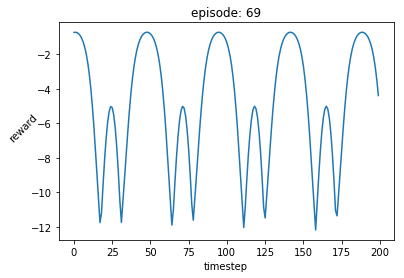

[-3.41929722]
[-3.40939951]
[-3.40613246]
[-3.40892744]
[-3.41274261]
[-3.41521549]
[-3.41738248]
[-3.41960335]
[-3.42225432]
[-3.42551613]
[-3.42943811]
[-3.4340198]
[-3.4393034]
[-3.44533372]
[-3.45221686]
[-3.45990252]
[-3.4679513]
[-3.4765594]
[-3.48808384]
[-3.50264478]
[-3.52002645]
[-3.53980541]
[-3.56041169]
[-3.57769322]
[-3.59153366]
[-3.61362219]
[-3.63998508]
[-3.66982627]
[-3.7034266]
[-3.74028826]
[-3.77938795]
[-3.81984806]
[-3.86012268]
[-3.90142393]
[-3.94460034]
[-4.00105095]
[-4.10290766]
[-4.20921993]
[-4.3032546]
[-4.37145996]
[-4.40327787]
[-4.44148731]
[-4.5290966]
[-4.64535761]
[-4.76842356]
[-4.89524174]
[-5.02252531]
[-5.1300478]
[-5.21576309]
[-5.28320599]
[-5.34211969]
[-5.41751575]
[-5.67547417]
[-5.91879177]
[-6.13952494]
[-6.32867241]
[-6.45739174]
[-6.4797554]
[-6.60115767]
[-6.72441816]
[-6.97745705]
[-7.23589802]
[-7.45185566]
[-7.59260368]
[-7.61924076]
[-7.56050205]
[-7.45149803]
[-7.40222645]
[-7.57535315]
[-7.7778368]
[-7.97742844]
[-8.18832111]
[-

[-9.78191185]
[-9.71600246]
[-9.71068954]
[-9.77669334]
[-9.91633797]
[-10.13305092]
[-10.42292786]
[-10.7765007]
[-11.0148735]
[-11.04757881]
[-11.07180977]
[-11.05820847]
[-11.00666237]
[-10.92337036]
[-10.75220871]
[-10.49488163]
[-10.20781994]
[-9.94058228]
[-9.77112961]
[-9.67634869]
[-9.67796898]
[-9.79323196]
[-10.0261879]
[-10.37451649]
[-10.68423462]
[-10.76130295]
[-10.87210464]
[-10.94669342]
[-10.97544098]
[-10.95684052]
[-10.8977747]
[-10.71051598]
[-10.44143486]
[-10.14837265]
[-9.89584351]
[-9.72997093]
[-9.63646221]
[-9.62549591]
[-9.70887756]
[-9.88877201]
[-10.17647552]
[-10.28853416]
[-10.31905174]
[-10.33654785]
[-10.31450653]
[-10.24621964]
[-10.13494015]
[-9.95835495]
[-9.67799282]
[-9.34157181]
[-8.9983139]
[-8.58139992]
[-8.14750671]
[-7.78480721]
[-7.52166986]
[-7.38009453]
[-7.42061138]
[-7.68710518]
[-7.96718264]
[-8.13065624]
[-8.16186333]
[-8.18654442]
[-8.17834187]
[-8.11867523]
[-7.96205616]
[-7.74058628]
[-7.33209038]
[-6.3740344]
[-5.4668045]
[-4.803254

[-9.61810493]
[-9.66479683]
[-9.71677971]
[-9.77476883]
[-10.23106575]
[-10.67088318]
[-11.0886097]
[-11.40959454]
[-11.6106987]
[-11.68486595]
[-11.64127064]
[-11.50117302]
[-11.29584503]
[-11.04292107]
[-10.78518677]
[-10.80759048]
[-11.03411388]
[-11.2583847]
[-11.45098686]
[-11.62384224]
[-11.77492714]
[-11.90693665]
[-12.02092075]
[-12.11971092]
[-12.20459366]
[-12.27717495]
[-12.33324432]
[-12.36981201]
[-12.38476944]
[-12.37140179]
[-12.32157898]
[-12.24093437]
[-12.11881256]
[-11.94808578]
[-11.73344326]
[-11.48010254]
[-11.21096611]
[-10.98346519]
[-10.79621887]
[-10.66881561]
[-10.60781193]
[-10.61035919]
[-10.680233]
[-10.99656487]
[-11.35523987]
[-11.74423599]
[-12.15571976]
[-12.58256721]
[-13.01984215]
[-13.44877052]
[-14.29574394]
[-15.07380009]
[-15.74842834]
[-16.21445274]
[-16.42650986]
[-16.38616562]
[-16.12633514]
[-15.69845295]
[-15.16214085]
[-14.5710907]
[-14.23056602]
[-14.21035004]
[-14.29669762]
[-14.38160801]
[-14.45354652]
[-14.52192879]
[-14.57984161]
[-14.

[-4.6340251]
[-4.47424412]
[-4.43569899]
[-4.40647078]
[-4.37124681]
[-4.35024452]
[-4.32316017]
[-4.29412079]
[-4.26690483]
[-4.25078011]
[-4.24610567]
[-4.24974298]
[-4.25777102]
[-4.26635933]
[-4.2725215]
[-4.27409935]
[-4.26950836]
[-4.25709057]
[-4.23510361]
[-4.22019148]
[-4.20630217]
[-4.18282461]
[-4.1522646]
[-4.11858416]
[-4.08581161]
[-4.05838919]
[-4.04346943]
[-4.03862095]
[-4.03976393]
[-4.0427599]
[-4.04410219]
[-4.04132748]
[-4.03266621]
[-4.01674891]
[-3.99227738]
[-3.95788646]
[-3.93949223]
[-3.9148674]
[-3.88431549]
[-3.85106301]
[-3.81848812]
[-3.78922987]
[-3.76838136]
[-3.75765038]
[-3.75348973]
[-3.75200152]
[-3.74987936]
[-3.74487305]
[-3.73562431]
[-3.72140241]
[-3.70196366]
[-3.67699242]
[-3.65117574]
[-3.63459945]
[-3.61544752]
[-3.5945487]
[-3.57442665]
[-3.55695128]
[-3.54154277]
[-3.53229332]
[-3.52846718]
[-3.5278399]
[-3.52830863]
[-3.52736783]
[-3.50368953]
[-3.44931102]
[-3.39926529]
[-3.35517097]
[-3.32169199]
[-3.29731703]
[-3.28873372]
[-3.30080819]

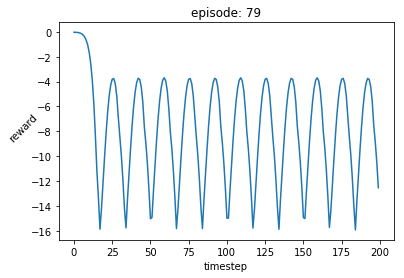

[-3.7210083]
[-3.72176194]
[-3.72138166]
[-3.72037649]
[-3.71745849]
[-3.71364069]
[-3.70888853]
[-3.70337534]
[-3.69730163]
[-3.6906693]
[-3.68288374]
[-3.67412972]
[-3.66404676]
[-3.65218496]
[-3.6389637]
[-3.62416768]
[-3.607831]
[-3.59020948]
[-3.57120442]
[-3.55120134]
[-3.52938843]
[-3.50777149]
[-3.4867382]
[-3.46955013]
[-3.45965886]
[-3.46086049]
[-3.47151446]
[-3.49294877]
[-3.52429628]
[-3.55520105]
[-3.57986856]
[-3.59623003]
[-3.60356545]
[-3.60553336]
[-3.60018992]
[-3.5887289]
[-3.57327247]
[-3.55705261]
[-3.54016781]
[-3.52289438]
[-3.50806427]
[-3.51634908]
[-3.5428226]
[-3.56957412]
[-3.57084274]
[-3.56702709]
[-3.56435061]
[-3.56276011]
[-3.56189322]
[-3.56123829]
[-3.56178474]
[-3.54961109]
[-3.53585315]
[-3.51745582]
[-3.4953301]
[-3.49389219]
[-3.49495506]
[-3.49532413]
[-3.4916923]
[-3.4813621]
[-3.46666837]
[-3.45371604]
[-3.44429398]
[-3.44234681]
[-3.44512773]
[-3.45153427]
[-3.45191765]
[-3.44604206]
[-3.43798161]
[-3.42619824]
[-3.41368151]
[-3.40718031]
[-3

[-3.3090117]
[-3.30709076]
[-3.30815458]
[-3.31311727]
[-3.3156898]
[-3.31635809]
[-3.31667829]
[-3.31672478]
[-3.31625724]
[-3.31546879]
[-3.31470203]
[-3.31428313]
[-3.31483507]
[-3.31623507]
[-3.31793642]
[-3.31930232]
[-3.31981516]
[-3.31918263]
[-3.31725883]
[-3.31406403]
[-3.30972672]
[-3.30467582]
[-3.2994616]
[-3.29423809]
[-3.28962874]
[-3.28588915]
[-3.28275537]
[-3.27921534]
[-3.27446175]
[-3.2669816]
[-3.25727534]
[-3.24744892]
[-3.23872805]
[-3.23035192]
[-3.2214179]
[-3.21207356]
[-3.20277166]
[-3.19436717]
[-3.19018888]
[-3.18764687]
[-3.19070005]
[-3.19950962]
[-3.20944095]
[-3.21556735]
[-3.21795273]
[-3.21553278]
[-3.20973969]
[-3.20193291]
[-3.1936996]
[-3.18713689]
[-3.18550897]
[-3.1888926]
[-3.19183826]
[-3.19090247]
[-3.19046831]
[-3.19100404]
[-3.19241786]
[-3.19357944]
[-3.19595504]
[-3.19326186]
[-3.19294691]
[-3.19402766]
[-3.19372249]
[-3.19114375]
[-3.18649459]
[-3.18657732]
[-3.19331503]
[-3.19863749]
[-3.2019062]
[-3.20211673]
[-3.19964075]
[-3.19280815]


[-2.80178642]
[-2.79267097]
[-2.78807425]
[-2.78760386]
[-2.79033375]
[-2.79580307]
[-2.7971549]
[-2.7975657]
[-2.79833364]
[-2.7925725]
[-2.7877872]
[-2.78339195]
[-2.77870774]
[-2.77361798]
[-2.76840878]
[-2.76313853]
[-2.75859332]
[-2.75598431]
[-2.75492167]
[-2.75565314]
[-2.75811577]
[-2.76161671]
[-2.76543641]
[-2.76927137]
[-2.77196431]
[-2.77400541]
[-2.7741847]
[-2.77050519]
[-2.76564622]
[-2.75799584]
[-2.74898291]
[-2.73875833]
[-2.72722745]
[-2.71457434]
[-2.70062494]
[-2.68563151]
[-2.69389272]
[-2.69595432]
[-2.69623804]
[-2.69039774]
[-2.68426442]
[-2.68073893]
[-2.69026613]
[-2.69773531]
[-2.70260048]
[-2.70489216]
[-2.70462894]
[-2.70184016]
[-2.70540214]
[-2.70593953]
[-2.70278454]
[-2.69602966]
[-2.68692017]
[-2.67565584]
[-2.66005707]
[-2.68078518]
[-2.69230938]
[-2.68725109]
[-2.66688871]
[-2.66971445]
[-2.66927457]
[-2.66509676]
[-2.68886971]
[-2.70870495]
[-2.715518]
[-2.71392155]
[-2.71217585]
[-2.703614]
[-2.69605136]
[-2.7041893]
[-2.75016904]
[-2.78778458]
[-

[-2.44890571]
[-2.3834331]
[-2.31960464]
[-2.26221871]
[-2.21416306]
[-2.192276]
[-2.19976473]
[-2.2235074]
[-2.27420211]
[-2.33325696]
[-2.39786625]
[-2.45556974]
[-2.49322605]
[-2.50455523]
[-2.52057195]
[-2.53884387]
[-2.55499077]
[-2.56125784]
[-2.55220175]
[-2.54427505]
[-2.53816438]
[-2.53370667]
[-2.5307498]
[-2.52916193]
[-2.52882957]
[-2.52965283]
[-2.53152084]
[-2.53433871]
[-2.53640389]
[-2.54090095]
[-2.54811811]
[-2.55772185]
[-2.56983876]
[-2.5836556]
[-2.59911776]
[-2.61575866]
[-2.63387084]
[-2.65301037]
[-2.67314672]
[-2.6948154]
[-2.72175479]
[-2.74893832]
[-2.77538419]
[-2.80233026]
[-2.82871819]
[-2.85874915]
[-2.88994575]
[-2.92364597]
[-2.95758057]
[-2.98980045]
[-3.00926423]
[-3.0182023]
[-3.01527333]
[-3.00196099]
[-2.98054218]
[-2.95217752]
[-2.91779613]
[-2.87504792]
[-2.83176422]
[-2.79969501]
[-2.79254866]
[-2.79007792]
[-2.79439044]
[-2.79871607]
[-2.80375075]
[-2.80985522]
[-2.81696725]
[-2.82490444]
[-2.83372283]
[-2.84334707]
[-2.85366035]
[-2.8645997]
[

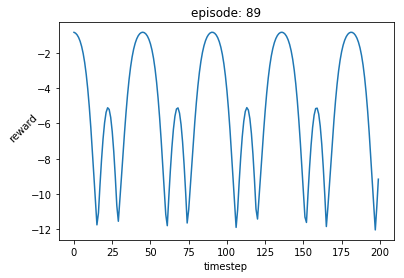

[-2.5343225]
[-2.51041031]
[-2.48636889]
[-2.46213412]
[-2.4382906]
[-2.41558838]
[-2.39404273]
[-2.37512612]
[-2.3591814]
[-2.34609389]
[-2.33585]
[-2.32943583]
[-2.32675314]
[-2.3274858]
[-2.33121777]
[-2.33758187]
[-2.34611487]
[-2.35618949]
[-2.36721587]
[-2.37864399]
[-2.38980246]
[-2.40065289]
[-2.41014123]
[-2.41788006]
[-2.42375016]
[-2.42772698]
[-2.43004155]
[-2.43100095]
[-2.43111324]
[-2.43099999]
[-2.43076062]
[-2.43075848]
[-2.43126678]
[-2.43260789]
[-2.43488407]
[-2.4381876]
[-2.44266701]
[-2.44817066]
[-2.45507097]
[-2.46367574]
[-2.47400331]
[-2.48618007]
[-2.49961829]
[-2.51402307]
[-2.52929831]
[-2.5456903]
[-2.56220603]
[-2.57880354]
[-2.59483695]
[-2.61003709]
[-2.62415838]
[-2.63576722]
[-2.64433789]
[-2.65003657]
[-2.65254974]
[-2.65338469]
[-2.65368581]
[-2.65398479]
[-2.65381384]
[-2.65342712]
[-2.65267491]
[-2.65156412]
[-2.6507194]
[-2.65088654]
[-2.65234041]
[-2.65449119]
[-2.65733552]
[-2.66011667]
[-2.66051626]
[-2.65795326]
[-2.65235782]
[-2.64336038]
[-

[-2.4546628]
[-2.46148896]
[-2.46871424]
[-2.47817707]
[-2.48736525]
[-2.49607348]
[-2.50412917]
[-2.51117444]
[-2.53243399]
[-2.56084681]
[-2.59103394]
[-2.62272716]
[-2.65606356]
[-2.69052649]
[-2.72613215]
[-2.76271343]
[-2.80021524]
[-2.83862472]
[-2.87720418]
[-2.9153471]
[-2.95203471]
[-2.98564267]
[-3.01421475]
[-3.03580928]
[-3.04824448]
[-3.04971528]
[-3.03842807]
[-3.01598692]
[-2.98429275]
[-2.94550896]
[-2.90249562]
[-2.85599279]
[-2.80775118]
[-2.7588172]
[-2.71044755]
[-2.66495943]
[-2.64125538]
[-2.63190103]
[-2.62250018]
[-2.61305547]
[-2.6036365]
[-2.59432197]
[-2.58498454]
[-2.57563663]
[-2.56611276]
[-2.55630374]
[-2.54611158]
[-2.53554773]
[-2.52460241]
[-2.51588035]
[-2.50602317]
[-2.49374795]
[-2.47924924]
[-2.4625783]
[-2.4440062]
[-2.42343116]
[-2.40084529]
[-2.37605023]
[-2.34947038]
[-2.32136369]
[-2.29174781]
[-2.25977898]
[-2.22589922]
[-2.19130802]
[-2.15676403]
[-2.12399793]
[-2.09801602]
[-2.07711363]
[-2.07019734]
[-2.06923294]
[-2.08408785]
[-2.1094768]

[-3.36455989]
[-3.37860727]
[-3.38533926]
[-3.3924334]
[-3.40336895]
[-3.41304088]
[-3.41247439]
[-3.40122771]
[-3.3835144]
[-3.36674094]
[-3.35114598]
[-3.33763051]
[-3.32670331]
[-3.3186326]
[-3.31344891]
[-3.31121588]
[-3.31202316]
[-3.31564498]
[-3.31802011]
[-3.31376863]
[-3.3092041]
[-3.30026436]
[-3.2863276]
[-3.27330971]
[-3.30096316]
[-3.32776427]
[-3.35371876]
[-3.38151002]
[-3.4065814]
[-3.4274292]
[-3.44326401]
[-3.45409036]
[-3.45847082]
[-3.45629668]
[-3.4488132]
[-3.43606901]
[-3.41935682]
[-3.40034413]
[-3.38364363]
[-3.3662405]
[-3.34860539]
[-3.33090854]
[-3.31423402]
[-3.29876852]
[-3.28446913]
[-3.27102208]
[-3.25925469]
[-3.25257111]
[-3.25326872]
[-3.26009369]
[-3.27284932]
[-3.28645396]
[-3.29775929]
[-3.30513477]
[-3.31311679]
[-3.31663561]
[-3.31674623]
[-3.31331038]
[-3.31188941]
[-3.30993366]
[-3.30538678]
[-3.29724455]
[-3.28547692]
[-3.27699757]
[-3.26753569]
[-3.26185083]
[-3.25792122]
[-3.27337885]
[-3.2973814]
[-3.31266379]
[-3.32063723]
[-3.32295585]
[-

[-3.61400557]
[-3.63740373]
[-3.65178585]
[-3.65662575]
[-3.65311217]
[-3.64289045]
[-3.62934351]
[-3.61367083]
[-3.59631824]
[-3.57847691]
[-3.56128955]
[-3.54528451]
[-3.53074598]
[-3.51779079]
[-3.50648546]
[-3.49668479]
[-3.48756289]
[-3.47898149]
[-3.46980977]
[-3.45963454]
[-3.44771314]
[-3.43245935]
[-3.41432428]
[-3.39351034]
[-3.37223816]
[-3.34915805]
[-3.32567191]
[-3.30145788]
[-3.2766664]
[-3.25212598]
[-3.22815561]
[-3.20482516]
[-3.18233442]
[-3.16153049]
[-3.14215851]
[-3.12455845]
[-3.10886741]
[-3.0952599]
[-3.08363986]
[-3.07377839]
[-3.06525636]
[-3.05758619]
[-3.05032945]
[-3.0431428]
[-3.03563309]
[-3.02773952]
[-3.01929116]
[-3.01010036]
[-3.0000236]
[-2.98914766]
[-2.97751403]
[-2.96512127]
[-2.95222735]
[-2.93884254]
[-2.92498207]
[-2.91067886]
[-2.89632177]
[-2.88192606]
[-2.86787558]
[-2.85434866]
[-2.84156966]
[-2.83004904]
[-2.82016826]
[-2.81234646]
[-2.80620861]
[-2.80193305]
[-2.80066252]
[-2.80132246]
[-2.80323434]
[-2.80648661]
[-2.80985117]
[-2.810864

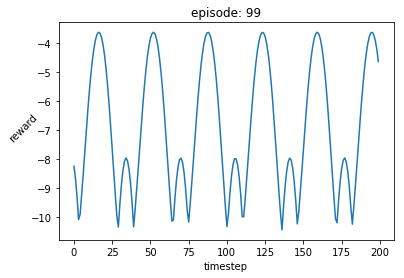

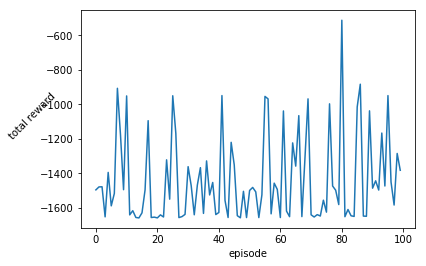

In [249]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy

ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
GAMMA = .9
LR_actor = .01
LR_critic = .01
EXPERIENCE_CAPACITY = 4000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 100
MAX_STEP = 400
BATCH_SIZE = 32
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 30)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 30)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fcO = nn.Linear(60, 1)
        self.fcO.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        s = F.relu(s)
        a = self.fcA(y)
        a = F.relu(a)
        o = self.fcO(torch.cat([s,a], 1))
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(30, N_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# functions
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    # update critic    
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.mean(critic(bat_o, actor(bat_o)))
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

# main
target_actor = Actor()
target_critic = Critic()
actor = Actor()
critic = Critic()
if use_cuda:
    target_actor.cuda()
    target_critic.cuda()
    actor.cuda()
    critic.cuda()
exp = Experience(EXPERIENCE_CAPACITY)
optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

vec_r = []
update_counter = 0
for epi in xrange(MAX_EPI):
    o = env.reset()
    acc_r = 0
    
    local_r = []
    for t in xrange(MAX_STEP):    
        a = choose_action(o, actor)
        print a
        o_, r, done, info = env.step(a)
        exp.push(o, a, r, o_)
        
        # update actor and critic every timestep
        update_actor_critic(target_actor, target_critic, \
                           actor, critic, exp, optim_actor, optim_critic)
        update_counter += 1
        
        # periodically hard update target network
        if update_counter % TARGET_UPDATE_FREQUENCY == 0:
            update_target(target_actor, target_critic, \
                         actor, critic)
        
        local_r.append(r)
        acc_r += r
        o = o_
        if done:
            break
    
    vec_r.append(acc_r)
    
    # plot rewards for some episode
    if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
        plt.plot(xrange(len(local_r)), local_r)
        plt.title('episode: {}'.format(epi))
        plt.xlabel('timestep')
        plt.ylabel('reward', rotation=45)
        plt.savefig('{}'.format(epi))
        plt.show()

# plot total reward for all episodes
plt.plot(xrange(len(vec_r)), vec_r)
plt.xlabel('episode')
plt.ylabel('total reward', rotation=45)
plt.savefig('total')
plt.show()

[2017-08-08 21:31:29,202] Making new env: Pendulum-v0


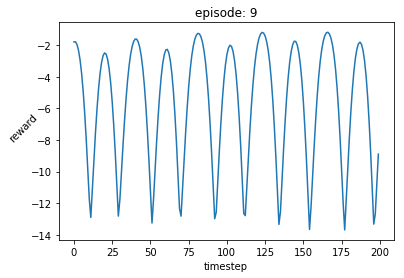

KeyboardInterrupt: 

In [250]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy

ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
GAMMA = .9
LR_actor = .01
LR_critic = .01
EXPERIENCE_CAPACITY = 4000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 100
MAX_STEP = 400
BATCH_SIZE = 32
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 30)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 30)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fcO = nn.Linear(60, 1)
        self.fcO.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        s = F.relu(s)
        a = self.fcA(y)
        a = F.relu(a)
        o = self.fcO(torch.cat([s,a], 1))
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(30, N_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# functions
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    # update critic    
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.mean(critic(bat_o, actor(bat_o)))
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

# main
target_actor = Actor()
target_critic = Critic()
actor = Actor()
critic = Critic()
if use_cuda:
    target_actor.cuda()
    target_critic.cuda()
    actor.cuda()
    critic.cuda()
exp = Experience(EXPERIENCE_CAPACITY)
optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

vec_r = []
update_counter = 0
for epi in xrange(MAX_EPI):
    o = env.reset()
    acc_r = 0
    
    local_r = []
    for t in xrange(MAX_STEP):    
        a = choose_action(o, actor)
        o_, r, done, info = env.step(a)
        exp.push(o, a, r, o_)
        
        # update actor and critic every timestep
        update_actor_critic(target_actor, target_critic, \
                           actor, critic, exp, optim_actor, optim_critic)
        update_counter += 1
        
        # periodically hard update target network
        if update_counter % TARGET_UPDATE_FREQUENCY == 0:
            update_target(target_actor, target_critic, \
                         actor, critic)
        
        local_r.append(r)
        acc_r += r
        o = o_
        if done:
            break
    
    vec_r.append(acc_r)
    
    # plot rewards for some episode
    if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
        plt.plot(xrange(len(local_r)), local_r)
        plt.title('episode: {}'.format(epi))
        plt.xlabel('timestep')
        plt.ylabel('reward', rotation=45)
        plt.show()

# plot total reward for all episodes
plt.plot(xrange(len(vec_r)), vec_r)
plt.xlabel('episode')
plt.ylabel('total reward', rotation=45)
plt.show()